# Sphere magnetostriction
- Code for large deformation soft-magentoelasticity of elastomeric materials

- Magnetic actuation of a spherical specimen using an Axisymmetric formulation.

### Units

- Basic:
    - Length: mm
    -   Time: s
    -   Mass: kg
    - Charge: kC
    
- Derived: 
    - Force: mN
    - Pressure: kPa
    - Current: kA
    - Mag. flux density: mT

### Software:
- Dolfinx v0.8.0

In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile


# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh, cosh, atan, atan2)

# basix finite elements
import basix
from basix.ufl import element, mixed_element, quadrature_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime


# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Geometry parameters
radius = 5.0   # radius of sphere, mm
scale = 50  # side length of air domain, mm

# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/sphere_air_5mm.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_sphere_air_5mm.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

# A single point for "grounding" the displacement and phi
def ground(x):
    # return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0))
    return  np.logical_and(np.isclose(x[1], 0), np.less_equal(x[0], radius))

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell index numbers**

In [3]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))          # printing the unique indices

[11 12]


**Print out the unique facet index numbers**

In [4]:
top_imap = domain.topology.index_map(1)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[ 9 10 13 14 15]


**Visualize reference configuration and boundary facets**

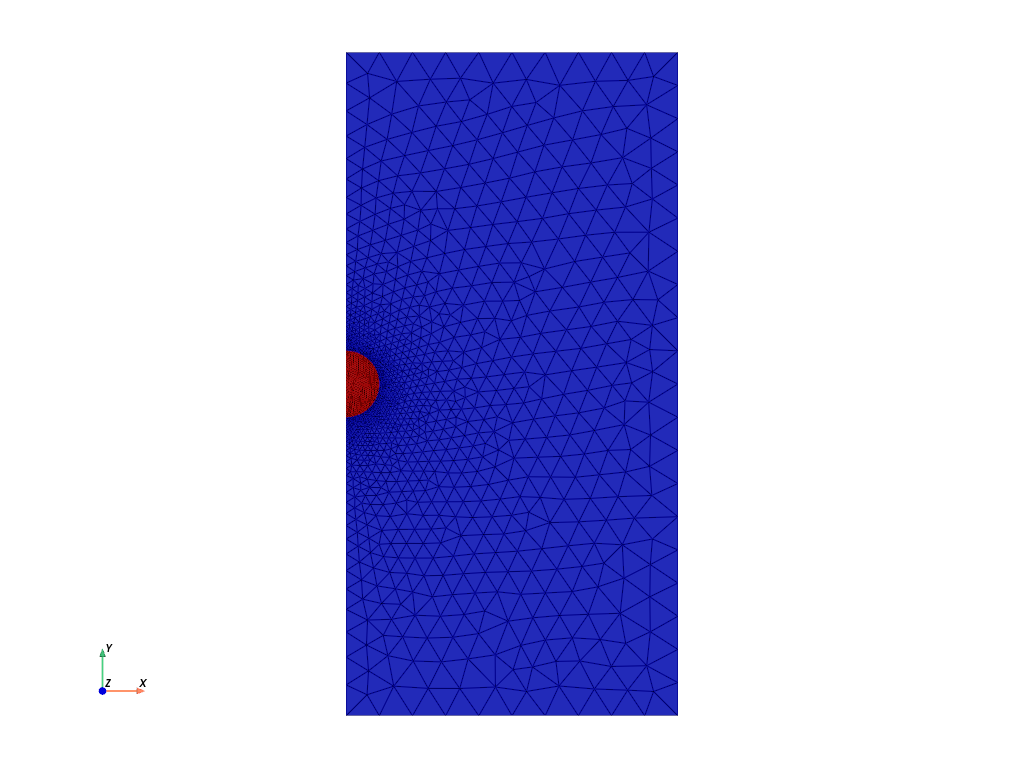

In [5]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 

# Add colored 1D surfaces for the named surfaces
mre_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==12]) )
air_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==11]) )
#
actor = plotter.add_mesh(mre_surf, show_edges=False,color="red") # mre is red
actor2 = plotter.add_mesh(air_surf, show_edges=False,color="blue") # air is blue

plotter.view_xy()

labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
plotter.add_axes(**labels)
    
plotter.screenshot("results/sphere_mesh.png")

from IPython.display import Image
Image(filename='results/sphere_mesh.png') 

## Define boundary and volume integration measure

In [6]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
# Here, we use the special measure 'dS' which denotes internal surfaces in UFL.
ds = ufl.Measure('dS', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, subdomain_data=cell_tags, metadata={'quadrature_degree': 2})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

#  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0])

# Material parameters

In [7]:
# A function for constructing spatially varying (piecewise-constant) material parameters

# Need some extra infrastructure for the spatially-discontinuous material property fields
Vmat = functionspace(domain, ("DG", 0)) # create a DG0 function space on the domain

def mat(prop_val_mre, prop_val_air):

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of shear moduli to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 12:
            prop.vector.setValueLocal(i, prop_val_mre)
        else:
            prop.vector.setValueLocal(i, prop_val_air)
            
    return prop

In [8]:
# Elasticity parameters
Gshear   = mat(411.0, 0.001) # Shear modulus, kPa
Kbulk    = mat(411.0e3, 101) # Nearly-incompressible

# Viscoelasticity parameters
#
# These params are a decent fit for hysteresis data at f=0.1, 1.0, 10 Hz
matParams = [150, 0.0159, 100.0, 0.159, 100, 1.59]
#
Gneq_1  = Constant(domain, PETSc.ScalarType(matParams[0]))    #  Non-equilibrium shear modulus, kPa
tau_1   = Constant(domain, PETSc.ScalarType(matParams[1]))    #  relaxation time, s
#
Gneq_2  = Constant(domain, PETSc.ScalarType(matParams[2]))    #  Non-equilibrium shear modulus, kPa
tau_2   = Constant(domain, PETSc.ScalarType(matParams[3]))     #  relaxation time, s
#
Gneq_3  = Constant(domain, PETSc.ScalarType(matParams[4]))    #  Non-equilibrium shear modulus, kPa
tau_3   = Constant(domain, PETSc.ScalarType(matParams[5]))    #  relaxation time, s

# Mass density
rho =  mat(2.833e-6, 0.0)  # 1e3 kg/m^3 = 1e-6 kg/mm^3

# Magnetization parameters 
#
# Vacuum permeability
mu0 = Constant(domain, 1.256e-6*1e9) # Vacuum permeability,  mN / mA^2
#
# material permeability (paramagnetic response)
chi = Constant(domain, 1.75) #mat(2.0, 0.0)# unitless magnetic susceptibility
mu  = mu0*(1.0 + chi) # magnetic permeability
ms  = Constant(domain, 0.495) # magnetic saturation value, kA/mm = MA/m

# Generalized-alpha method parameters
alpha   = Constant(domain, 0.0) # Set \alpha=0, since we observe no spurious pressure oscillations
gamma   = Constant(domain, PETSc.ScalarType(0.5+alpha))
beta    = Constant(domain, PETSc.ScalarType((gamma+0.5)**2/4.))

# Switch for whether the domain is the air or not
TairInd   = mat( 0, 1)

# Simulation time-control related params

In [9]:
# Simulation time control-related params
t    = 0.0         # start time (s)
Ttot = 20         # total simulation time (s) 
h_app_mag = 1500/float(mu0) # final h-field, 1500 mT b-field converted to (kA/mm)
numSteps = 60
dt   = Constant(domain, PETSc.ScalarType(Ttot/numSteps))       # (fixed) initial step size
period = Ttot

# Compiler variable for time step
dk = Constant(domain, PETSc.ScalarType(dt))

# Boundary condition to ramp up magnetic scalar potential
def phiRamp(t):
    
    phi_val = h_app_mag*2.0*scale*2.0*np.abs(t/period - np.floor(t/period + 0.5))
    
    # add a small offset to prevent the magnetic field from going completely back to zero upon unloading
    phi_val += 1e-3*h_app_mag*scale
    
    return phi_val 

# Boundary condition to ramp up magnetic field
def hRamp(t):
    
    h_mag_val = h_app_mag*2.0*np.abs(t/period - np.floor(t/period + 0.5))
    
    return h_mag_val


# Function spaces

In [10]:

U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,))  # For displacement
P1 = element("DG", domain.basix_cell(), 0)  # For pressure (must be DG to accomodate different materials)
P2 = element("Lagrange", domain.basix_cell(), 2)  # For phi
P0 = quadrature_element(domain.basix_cell(), degree=2, scheme="default") 
T0 = basix.ufl.blocked_element(P0, shape=(3,3)) # for Cv
#
TH = mixed_element([U2, P1, P2])     # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs
#
V1 = functionspace(domain, P1) # Scalar function space.
V1_2 = functionspace(domain, P2) # Scalar (quadratic) function space.
V2 = functionspace(domain, U2) # Vector function space
V3 = functionspace(domain, T0) # Tensor function space
#
# Define actual functions with the required DOFs
w         = Function(ME)
u, p, phi = split(w)  

# A copy of functions to store values in the previous step
w_old              = Function(ME)
u_old,  p_old, phi_old = split(w_old)   

# Define test functions        
u_test, p_test, phi_test = TestFunctions(ME)    

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)  

# Define a tensor-valued function for Cv.
Cv_1_old = Function(V3) 
Cv_2_old = Function(V3) 
Cv_3_old = Function(V3) 

# Functions for storing the velocity and acceleration at prev. step
v_old = Function(V2)
a_old = Function(V2)


# Initial conditions

- The initial conditions for degrees of freedom $\mathbf{u}$, $\mathbf{v}$, $\mathbf{a}$, $p$, and $\phi$ are zero everywhere
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the initial condition that $\mathbf{C}^v = \mathbf{1}$. This is done below.

In [11]:
# A function for constructing the identity matrix.
#
# To use the interpolate() feature, this must be defined as a 
# function of x.
def identity(x):
    values = np.zeros((3*3,
                      x.shape[1]), dtype=np.float64)
    values[0] = 1
    values[4] = 1
    values[8] = 1
    return values

# interpolate the identity onto the tensor-valued Cv function.
Cv_1_old.interpolate(identity)  
Cv_2_old.interpolate(identity)  
Cv_3_old.interpolate(identity)  

# Subroutines for kinematics and constitutive equations

In [12]:
#------------------------------------------------------------- 
# Utility subroutines
#-------------------------------------------------------------
 
# Subroutine for a "safer" sqrt() function which avoids a divide by zero 
# when automatically differentiated. 
def safe_sqrt(x):
    return sqrt(x + 1.0e-16)

# Hyperbolic secant function
def sech(x):
    return 1.0/cosh(x)

#-------------------------------------------------------
# Subroutines for axisymmetry  
#-------------------------------------------------------

# Special gradient operators for axisymmetric functions 
#
# Gradient of vector field u   
def axi_grad_vector(u):
    
    grad_u = grad(u)
    
    axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
    
    axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, axi_grad_33_exp]]) 
    
    return axi_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def axi_grad_scalar(y):
    
    grad_y = grad(y)
    
    axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
    
    return axi_grad_y

# Axisymmetric deformation gradient 
def F_axi_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
    
    F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
    
    F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
      
    F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F
    
    return F_axi

def h_calc(u, phi):
    
    F = F_axi_calc(u)
    
    h_R = -axi_grad_scalar(phi)
    
    h_sp = inv(F.T)*h_R
    
    return h_sp
#------------------------------------------------------------- 
# Subroutines for computing the viscous flow update
#-------------------------------------------------------------

# subroutine for the distortional part / unimodular part of a tensor A
def dist_part(A):

    Abar = A / (det(A)**(1.0/3.0))

    return Abar

# Subroutine for computing the viscous stretch Cv at the end of the step.
def Cv_update(u, Cv_old, tau_r):
    
   F = F_axi_calc(u)
   
   J = det(F)
   
   C = F.T*F
   
   Cv_new = dist_part( Cv_old + ( dk / tau_r ) * J**(-2./3.) * C ) 
    
   return Cv_new

#------------------------------------------------------------- 
# Subroutines for calculating the equilibrium Piola stress
#-------------------------------------------------------------

# Subrountine for computing the effective stretch
def lambdaBar_calc(u):
    
    F = F_axi_calc(u)
    
    J = det(F)
    
    Fbar = J**(-1/3)*F
    
    Cbar = Fbar.T*Fbar
    
    I1 = tr(Cbar)
    
    lambdaBar = safe_sqrt(I1/3.0)
    
    return lambdaBar

# Subroutine for calculating the  equilibrium Cauchy stress
def T_eq_calc(u,p,phi):
    
    F   = F_axi_calc(u)
    
    J = det(F)
    
    Fbar = J**(-1/3)*F
    
    Bbar = Fbar*Fbar.T

    T_eq = (1/J) * Gshear * dev(Bbar) - p * Identity(3)
    
    return T_eq

# Subroutine for the non-equilibrium Cauchy stress.
def T_neq_calc(u, Cv, Gneq):
        
    F  = F_axi_calc(u)
    
    J = det(F)
    
    C = F.T*F
    
    T_neq = J**(-5./3.) * Gneq * (F * inv(Cv) * F.T - (1./3.) * inner(C, inv(Cv)) * Identity(3) ) 
    
    return T_neq

# Subroutine for calculating the Magnetic Cauchy stress
def T_mag_calc(u, phi):
    
    h_sp = h_calc(u, phi)
    
    h_norm = safe_sqrt( dot(h_sp, h_sp) )
    
    T_mag_maxw = mu0 * (outer(h_sp, h_sp) - (1./2.) * dot(h_sp, h_sp) * Identity(3) )
    
    T_mag_para = - mu0 * ( (ms**2) / chi ) * ln( cosh( ( chi / ms ) * h_norm ) ) * Identity(3) \
                 + mu0 * ( ms / h_norm ) * tanh( ( chi / ms ) * h_norm ) * outer(h_sp, h_sp)
    
    # Exclude the paramagnetic response in the air domain.
    T_mag = T_mag_maxw + conditional(eq(TairInd,1), 0.0*Identity(3), T_mag_para)
    
    return T_mag


def Piola_calc(u, p, phi, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3):
    
    F = F_axi_calc(u)
    
    J = det(F)
    
    T_eq = T_eq_calc(u, p, phi)

    T_neq_1 = T_neq_calc(u, Cv_1, Gneq_1)
    
    T_neq_2 = T_neq_calc(u, Cv_2, Gneq_2)

    T_neq_3 = T_neq_calc(u, Cv_3, Gneq_3)
    
    T_mag = T_mag_calc(u, phi)
    
    T = T_eq +  conditional(eq(TairInd,1), 0.0*Identity(3),+ T_mag \
                                   + T_neq_1 + T_neq_2 + T_neq_3 )

    Piola = J * T * inv(F.T)
    
    return Piola

#------------------------------------------------------------- 
# Subroutines for calculating the magnetic flux density
#-------------------------------------------------------------


def b_R_calc(u, phi):

    F = F_axi_calc(u)
    
    J = det(F)
    
    h_sp = h_calc(u, phi)
    
    h_norm = safe_sqrt( dot(h_sp, h_sp) )
    
    b_maxw = mu0 * h_sp
    
    b_para = mu0 * ( ms / h_norm ) * tanh( ( chi / ms ) * h_norm ) * h_sp
    
    # Exclude the paramagnetic response in the air domain.
    b_sp = b_maxw + conditional(eq(TairInd,1), ufl.as_vector([0.,0.,0.]), b_para) 
    
    b_R = J * inv(F) * b_sp
    
    return b_R

def Piola_out(u, phi):

    F = F_axi_calc(u)

    J = det(F)

    # Calculate the Maxwell stress in the air
    h_sp = h_calc(u, phi)
    
    T_max = mu0 * (outer(h_sp, h_sp) - (1./2.) * dot(h_sp, h_sp) * Identity(3) )

    # map it to the Piola stress   
    Piola_out = J*T_max*inv(F.T)

    return Piola_out

def Cauchy_out(u, phi):

    # Calculate the Maxwell stress in the air
    h_sp = h_calc(u, phi)
    
    T_max = mu0 * (outer(h_sp, h_sp) - (1./2.) * dot(h_sp, h_sp) * Identity(3) )

    return T_max

#---------------------------------------------------------------------
# Subroutine for updating  acceleration using the Newmark beta method:
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
#---------------------------------------------------------------------
def update_a(u, u_old, v_old, a_old):
    return (u-u_old-dk*v_old)/beta/dk**2 - (1-2*beta)/2/beta*a_old

#---------------------------------------------------------------------
# Subroutine for updating  velocity using the Newmark beta method
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
#---------------------------------------------------------------------
def update_v(a, u_old, v_old, a_old):
    return v_old + dk*((1-gamma)*a_old + gamma*a)

#---------------------------------------------------------------------
# alpha-method averaging function
#---------------------------------------------------------------------
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new


# Evaluate kinematics and constitutive relations

In [13]:
# Get acceleration and velocity at end of step
a_new = update_a(u, u_old, v_old, a_old)
v_new = update_v(a_new, u_old, v_old, a_old)

# get avg (u,p) fields for generalized-alpha method
u_avg  = avg(u_old, u, alpha)
p_avg  = avg(p_old, p, alpha)
phi_avg  = avg(phi_old, phi, alpha)

# kinematical quantities
F  = F_axi_calc(u_avg)
J  = det(F)
lambdaBar = lambdaBar_calc(u_avg)

# update the Cv tensors
Cv_1 = Cv_update(u_avg, Cv_1_old, tau_1)
Cv_2 = Cv_update(u_avg, Cv_2_old, tau_2)
Cv_3 = Cv_update(u_avg, Cv_3_old, tau_3)

#  Evaulate the total Piola stress
Piola = Piola_calc(u_avg, p_avg, phi_avg, Cv_1, Cv_2, Cv_3, Gneq_1, Gneq_2, Gneq_3)

T_mag = T_mag_calc(u_avg, phi_avg)
T_eq  = T_eq_calc(u_avg, p_avg, phi_avg)

# Evaluate the magnetic flux density
b_R = b_R_calc(u_avg, phi_avg)

# Weak forms

In [14]:
# Where TairInd on the '+' side is equal to 1, the '-' side indicates the MRE. 
# Thus we use the following form of the maxwell traction, where:
# -> J, F, and n are those of the MRE on the '-' side.
# -> Cauchy_out is that of the Air on the '+' side.
#
# The leading factor of TairInd('+') acts as a conditional, 
# which makes sure that this traction is zero where the MRE is on the '+' side.
#
maxw_trac_plus = TairInd('+')*dot(J('-')*Cauchy_out(u_avg, phi_avg)('+')*inv(F.T)('-'),n('-'))

# Where TairInd on the '-' side is equal to 1, the '+' side indicates the MRE. 
# Thus we use the following form of the maxwell traction, where:
# -> J, F, and n are those of the MRE on the '+' side.
# -> Cauchy_out is that of the Air on the '-' side.
#
# The leading factor of TairInd('-') acts as a conditional, 
# which makes sure that this traction is zero where the MRE is on the '-' side.
#
maxw_trac_minus = TairInd('-')*dot(J('+')*Cauchy_out(u_avg, phi_avg)('-')*inv(F.T)('+'),n('+'))

# The total maxwell traction on ds_out will be the contribution of both of these terms, where:
# -> maxw_trac_plus applies on portions of ds_out where the air is on the '+' side
# -> maxw_trac_minus applies on portions of ds_out where the air is on the '-' side
# -> the whole boundary must have one of these two conditions, so together they cover the whole domain. 
#
maxw_trac = maxw_trac_plus + maxw_trac_minus

In [15]:
# The weak form for the equilibrium equation
#
Res_1  =  inner( Piola, axi_grad_vector(u_test))*x[0]*dx \
    - inner(maxw_trac, ufl.avg(ufl.as_vector([u_test[0], u_test[1], 0.0])) )*x[0]*ds(13) \
    + inner(rho * a_new, u_test)*x[0]*dx 

# The auxiliary equation for the pressure
#
Res_2 = inner((J-1) + p_avg/Kbulk, p_test)*x[0]*dx

# Weak form of Gauss's Law for magnetism
Res_3 = inner( b_R,  axi_grad_scalar(phi_test) )*x[0]*dx 

# The total residual
Res = Res_1 + Res_2 + Res_3 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [16]:
# results file name
results_name = "Axi_sphere_air_5mm_v2"

# Function space for projection of results
P1 = element("DG", domain.basix_cell(), 1)
VV1 = fem.functionspace(domain, P1) # linear scalar function space
#
U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) 
VV2 = fem.functionspace(domain, U1) # linear Vector function space
#
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) 
VV3 = fem.functionspace(domain, T1) # linear tensor function space

def setup_projection(u, V):

    trial = ufl.TrialFunction(V)
    test  = ufl.TestFunction(V)   

    a = ufl.inner(trial, test)*x[0]*dx
    L = ufl.inner(u, test)*x[0]*dx

    projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
        petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
    
    return projection_problem

Piola_projection = setup_projection(Piola*F.T/J, VV3)
Piola_temp = Piola_projection.solve()

T22_projection = setup_projection(Piola_temp[1,1], VV1)
T22_temp = T22_projection.solve()
T22_temp.name = "T22 projection"

# Piola_projection = setup_projection(Piola, VV3)
# Piola_temp = Piola_projection.solve()

# T     = Piola*F.T/J

# T22_projection = setup_projection(T[1,1], VV1)
# T22_temp = T22_projection.solve()
# T22_temp.name = "T22 projection"

T22_projection1 = setup_projection(T_mag[1,1], VV1)
T22_temp1 = T22_projection1.solve()
T22_temp1.name = "T22 mag projection"

p_proj = setup_projection(p, VV1)
p_vis = p_proj.solve()
p_vis.name = "p"


In [17]:
# primary fields to write to output file
u_vis      = Function(VV2, name="disp")
phi_vis    = Function(VV1, name="phi")

In [18]:

# Mises stress
T     = Piola_temp*F.T/J
T0    = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(VV1,name="Mises")
Mises_expr = Expression(Mises,VV1.element.interpolation_points())

# Cauchy stress components
T11 = Function(VV1)
T11.name = "T11"
T11_expr = Expression(T[0,0],VV1.element.interpolation_points())

T12 = Function(VV1)
T12.name = "T12"
T12_expr = Expression(T[0,1],VV1.element.interpolation_points())

T22 = Function(VV1)
T22.name = "T22"
T22_expr = Expression(T[1,1],VV1.element.interpolation_points())

T33 = Function(VV1)
T33.name = "T33"
T33_expr = Expression(T[2,2],VV1.element.interpolation_points())

F22 = Function(VV1)
F22.name = "F22"
F22_expr = Expression(F[1,1],VV1.element.interpolation_points())


In [19]:
# Effective stretch
lambdaBar_vis      = Function(VV1)
lambdaBar_vis.name = "LambdaBar"
lambdaBar_expr     = Expression(lambdaBar, VV1.element.interpolation_points())

# Volumetric deformation
J_vis      = Function(VV1)
J_vis.name = "J"
J_expr     = Expression(J, VV1.element.interpolation_points())

In [20]:
# air flag
TairInd_vis      = Function(VV1)
TairInd_vis.name = "Air flag"
TairInd_expr     = Expression(TairInd, VV1.element.interpolation_points())

In [21]:
# h-, b-, and m-fields
h_vis      = Function(VV2)
h_vis.name = "h-field"
h_sp       = h_calc(u, phi)
h_2D       = ufl.as_vector([h_sp[0], h_sp[1]])
h_vis_expr = Expression(h_2D, VV2.element.interpolation_points())
#
b_vis      = Function(VV2)
b_vis.name = "b-field, T"
b_sp       = (F * b_R_calc(u, phi) / J)/1e3
b_2D       = ufl.as_vector([b_sp[0], b_sp[1]])
b_vis_expr = Expression(b_2D, VV2.element.interpolation_points())
#
m_vis      = Function(VV2)
m_vis.name = "m-field"
m_sp       = b_sp*1e3/mu0 - h_sp
m_2D       = ufl.as_vector([m_sp[0], m_sp[1]])
m_vis_expr = Expression(m_2D, VV2.element.interpolation_points())

# Magnitude of magnetic fields
h_mag_vis      = Function(VV1)
h_mag_vis.name = "h-field magnitude"
h_mag          = safe_sqrt(dot(h_sp, h_sp))
h_mag_expr     = Expression(h_mag, VV1.element.interpolation_points())
#
b_mag_vis      = Function(VV1)
b_mag_vis.name = "b-field magnitude, T"
b_mag          = safe_sqrt(dot(b_sp, b_sp))
b_mag_expr     = Expression(b_mag, VV1.element.interpolation_points())
#
m_mag_vis      = Function(VV1)
m_mag_vis.name = "m-field magnitude"
m_mag          = safe_sqrt(dot(m_sp, m_sp))
m_mag_expr     = Expression(m_mag, VV1.element.interpolation_points())

# induced h- and b-fields
#
# Constant for applied h-field
h_cons = Constant(domain,PETSc.ScalarType(hRamp(0)))
#
h_ind_vis      = Function(VV2)
h_ind_vis.name = "Induced h-field"
h_ind_sp       = h_calc(u, phi) - ufl.as_vector([0, h_cons, 0])
h_ind_2D       = ufl.as_vector([h_ind_sp[0], h_ind_sp[1]])
h_ind_vis_expr = Expression(h_ind_2D, VV2.element.interpolation_points())
#
b_ind_vis      = Function(VV2)
b_ind_vis.name = "Induced b-field, T"
b_ind_sp       = (F * b_R_calc(u, phi) / J - mu0 * ufl.as_vector([0, h_cons, 0]))/1e3
b_ind_2D       = ufl.as_vector([b_ind_sp[0], b_ind_sp[1]])
b_ind_vis_expr = Expression(b_ind_2D, VV2.element.interpolation_points())

In [22]:
# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, phi_vis, # DOF outputs
        Mises_vis, T11, T12, T22, T22_temp, T22_temp1, T33,  F22, # stress outputs
        lambdaBar_vis, J_vis, # Kinematical outputs
        TairInd_vis, # material params
        h_vis, b_vis, m_vis, h_ind_vis, b_ind_vis, # magnetic outputs
    ],
    engine="BP4",
)

def writeResults(t):
    
    # Update the output fields before writing to VTX.
    #
    u_vis.interpolate(w.sub(0))
    p_vis = p_proj.solve()
    phi_vis.interpolate(w.sub(2))
    #
    # re-project to smooth visualization of quadrature functions
    # before interpolating.
    Piola_temp = Piola_projection.solve()
    T22_temp = T22_projection.solve()
    T22_temp1 = T22_projection1.solve()
    Mises_vis.interpolate(Mises_expr)
    T11.interpolate(T11_expr)
    T12.interpolate(T12_expr)
    T22.interpolate(T22_expr)
    T33.interpolate(T33_expr)
    F22.interpolate(F22_expr)
    #
    lambdaBar_vis.interpolate(lambdaBar_expr)
    J_vis.interpolate(J_expr)
    #
    TairInd_vis.interpolate(TairInd_expr)
    #
    h_vis.interpolate(h_vis_expr)
    b_vis.interpolate(b_vis_expr)
    m_vis.interpolate(m_vis_expr)
    #
    h_mag_vis.interpolate(h_mag_expr)
    b_mag_vis.interpolate(b_mag_expr)
    m_mag_vis.interpolate(m_mag_expr)
    #
    h_ind_vis.interpolate(h_ind_vis_expr)
    b_ind_vis.interpolate(b_ind_vis_expr)
       
    # Finally, write output fields to VTX.
    #
    file_results.write(t) 

In [23]:
P1_Lg = element("Lagrange", domain.basix_cell(), 1)
VV1_Lg = fem.functionspace(domain, P1_Lg) # linear lagrange scalar function space
TairInd_lg_vis = Function(VV1_Lg, name="Air flag")

U1_Lg = element("Lagrange", domain.basix_cell(), 1, shape=(2,)) 
VV2_Lg = fem.functionspace(domain, U1_Lg) # linear lagrange Vector function space
u_lg_vis = Function(VV2_Lg, name="disp")

In [24]:
# set up the output VTX files.
file_results_bound = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + "_boundary.bp",
    [  # put the functions here you wish to write to output
        u_lg_vis, TairInd_lg_vis,
    ],
    engine="BP4",
)

def writeResults_bound(t):
    
    # Update the output fields before writing to VTX.
    #
    u_lg_vis.interpolate(w.sub(0))
    TairInd_lg_vis.interpolate(TairInd_expr)
    
    # Finally, write output fields to VTX.
    #
    file_results_bound.write(t) 

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [25]:
# infrastructure for evaluating functions at a certain point efficiently
pointForEval = np.array([0.0, radius, 0.0])
bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForEval).array
#
# infrastructure for evaluating functions at a certain point efficiently
pointForEval2 = np.array([0.0, 0.0, 0.0])
cell_candidates2 = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval2)
colliding_cells2 = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates2, pointForEval2).array
#
pointForEval3 = np.array([0.0, -radius, 0.0])
cell_candidates3 = dolfinx.geometry.compute_collisions_points(bb_tree, pointForEval3)
colliding_cells3 = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates3, pointForEval3).array

## Boundary condtions

In [26]:
# Constant for applied displacement
phi_cons = Constant(domain,PETSc.ScalarType(phiRamp(0)))

# Find the specific DOFs which will be constrained.
left_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(15))
#
right_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(14))
top_u1_dofs   = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(9))
btm_u1_dofs   = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(10))
#
right_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(14))
top_u2_dofs   = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(9))
btm_u2_dofs   = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(10))
#
top_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(9))
btm_phi_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(10))

# Zero bc quantity
V0, submap = ME.sub(0).sub(1).collapse()
fixed_u_dofs = fem.locate_dofs_geometrical((ME.sub(0).sub(1), V0), ground)
fixed_disp = Function(V0)
fixed_disp.interpolate(lambda x:  np.zeros(x.shape[1]) )

# building Dirichlet BCs
bcs_0 = dirichletbc(0.0, left_u1_dofs, ME.sub(0).sub(0))    # u1 fix - left
#
bcs_1 = dirichletbc(0.0, right_u1_dofs, ME.sub(0).sub(0))    # u1 fix - right
bcs_2 = dirichletbc(0.0, top_u1_dofs,   ME.sub(0).sub(0))    # u1 fix - top
bcs_3 = dirichletbc(0.0, btm_u1_dofs,   ME.sub(0).sub(0))    # u1 fix - btm
#
bcs_4 = dirichletbc(0.0, right_u2_dofs, ME.sub(0).sub(1))    # u2 fix - right
bcs_5 = dirichletbc(0.0, top_u2_dofs,   ME.sub(0).sub(1))    # u2 fix - top
bcs_6 = dirichletbc(0.0, btm_u2_dofs,   ME.sub(0).sub(1))    # u2 fix - btm
#
bcs_7 = dirichletbc(0.0, top_phi_dofs, ME.sub(2))      # phi fix - Top
bcs_8 = dirichletbc(phi_cons, btm_phi_dofs, ME.sub(2)) # phi ramp - Btm
#
bcs_9 = dirichletbc(fixed_disp, fixed_u_dofs, ME.sub(0).sub(1)) # u fix - center node

bcs = [bcs_0, bcs_1, bcs_2, bcs_3, bcs_4, bcs_5, bcs_6, bcs_7, bcs_8, bcs_9]


## Define the nonlinear variational problem

In [27]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()


##  Start calculation loop

In [28]:
# Give the step a descriptive name
step = "Actuate"

# Variables for storing time history
totSteps = 1000000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2a = np.zeros(shape=[totSteps]) 
timeHist2b = np.zeros(shape=[totSteps]) 
timeHist3 = np.zeros(shape=[totSteps])
timeHist4 = np.zeros(shape=[totSteps])
timeHist5 = np.zeros(shape=[totSteps])

#Iinitialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0)    
writeResults_bound(t=0.0)  

#  Set up temporary "helper" functions and expressions 
#  for updating the internal variables.
#
# For the Cv tensors:
Cv_1_temp = Function(V3)
Cv_1_expr = Expression(Cv_1, V3.element.interpolation_points())
#
Cv_2_temp = Function(V3)
Cv_2_expr = Expression(Cv_2, V3.element.interpolation_points())
#
Cv_3_temp = Function(V3)
Cv_3_expr = Expression(Cv_3, V3.element.interpolation_points())
#
# and also for the velocity and acceleration.
v_temp = Function(V2)
a_temp = Function(V2)
#
v_expr = Expression(v_new,V2.element.interpolation_points())
a_expr = Expression(a_new,V2.element.interpolation_points())

# print a message for simulation startup
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    phi_cons.value = float(phiRamp(t))
    h_cons.value   = float(hRamp(t))
    
    # Solve the problem
    (iter, converged) = solver.solve(w)
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Print progress of calculation periodically
    if ii%1 == 0:      
      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
      print("dt: {} s | Simulation Time: {} s  of  {} s".format(round(dt, 4), round(t,4), Ttot))
      print()   
      
    # Write output to file
    writeResults(t)
    writeResults_bound(t)
       
    # Store time history variables at this time  
    timeHist0[ii] = t # current time 
    #
    timeHist1[ii] = hRamp(t) # time history of applied h-field
    #
    timeHist2a[ii] = w.sub(0).sub(1).eval([0, radius, 0],colliding_cells[0])[0] # time history of vertical displacement 
    #
    timeHist2b[ii] = w.sub(0).sub(1).eval([0, -radius, 0],colliding_cells3[0])[0] # time history of vertical displacement 
    #
    timeHist3[ii] = h_mag_vis.eval([0, 0, 0],colliding_cells2[0])[0] # time history of h-field
    #
    timeHist4[ii] = b_mag_vis.eval([0, 0, 0],colliding_cells2[0])[0] # time history of b-field
    #
    timeHist5[ii] = m_mag_vis.eval([0, 0, 0],colliding_cells2[0])[0] # time history of m-field    
    
    # update internal variables 
    #
    # interpolate the values of the internal variables into their "temp" functions
    Cv_1_temp.interpolate(Cv_1_expr)
    Cv_2_temp.interpolate(Cv_2_expr)
    Cv_3_temp.interpolate(Cv_3_expr)
    #
    v_temp.interpolate(v_expr)
    a_temp.interpolate(a_expr)

    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
    
    # update the old values of internal variables for next step
    Cv_1_old.x.array[:] = Cv_1_temp.x.array[:]
    Cv_2_old.x.array[:] = Cv_2_temp.x.array[:]
    Cv_3_old.x.array[:] = Cv_3_temp.x.array[:]
      #
    v_old.x.array[:] = v_temp.x.array[:]
    a_old.x.array[:] = a_temp.x.array[:]
    
# close the output file.
file_results.close()
file_results_bound.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Actuate |   Increment: 1 | Iterations: 4
dt: 0.3333 s | Simulation Time: 0.3333 s  of  20 s

Step: Actuate |   Increment: 2 | Iterations: 4
dt: 0.3333 s | Simulation Time: 0.6667 s  of  20 s

Step: Actuate |   Increment: 3 | Iterations: 4
dt: 0.3333 s | Simulation Time: 1.0 s  of  20 s

Step: Actuate |   Increment: 4 | Iterations: 4
dt: 0.3333 s | Simulation Time: 1.3333 s  of  20 s

Step: Actuate |   Increment: 5 | Iterations: 4
dt: 0.3333 s | Simulation Time: 1.6667 s  of  20 s

Step: Actuate |   Increment: 6 | Iterations: 4
dt: 0.3333 s | Simulation Time: 2.0 s  of  20 s

Step: Actuate |   Increment: 7 | Iterations: 4
dt: 0.3333 s | Simulation Time: 2.3333 s  of  20 s

Step: Actuate |   Increment: 8 | Iterations: 4
dt: 0.3333 s | Simulation Time: 2.6667 s  of  20 s

Step: Actuate |   Increment: 9 | Iterations: 4
dt: 0.3333 s | Simulation Time: 3.0 s  of  20 s

Step: Actuate |   Increment

# Plot results

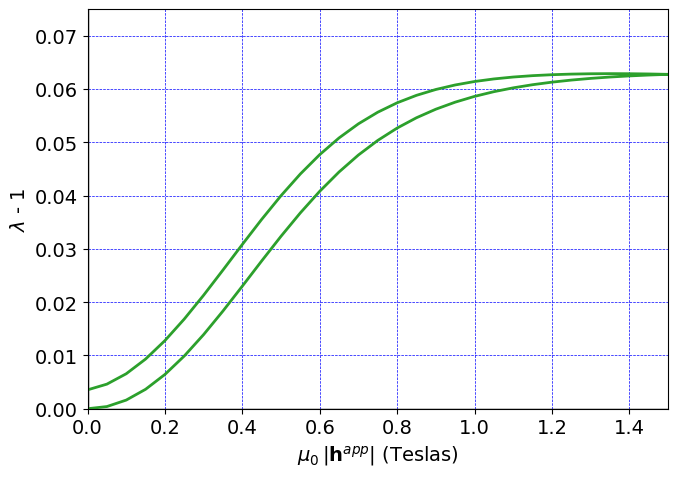

In [29]:
# Set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0) +1

plt.figure()
plt.axvline(0, c='k', linewidth=1.)
plt.axhline(0, c='k', linewidth=1.)
plt.plot(float(mu0)*timeHist1[0:ind]/1e3,  (timeHist2a[0:ind] - timeHist2b[0:ind])/(2*radius), linewidth=2.0, color=colors[2])
plt.axis('tight')
plt.ylabel(r"$\lambda$ - 1")
plt.xlabel(r"$\mu_0 \, |\mathbf{h}^{app}|$ (Teslas)")
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.ylim(0,0.075)
plt.xlim(0,1.5) #0.6*np.pi)
# plt.legend()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/2D_ax_sphere_air_stretch.png", dpi=600)

In [30]:
 (timeHist2a[ind-1] - timeHist2b[ind-1])/(2*radius)

0.0035379495517250414

In [31]:
stretchData = np.array([float(mu0)*timeHist1[0:ind]/1e3,  (timeHist2a[0:ind] - timeHist2b[0:ind])/(2*radius)])
np.savetxt("results/5mm_stretch_data.csv", stretchData, delimiter=",")

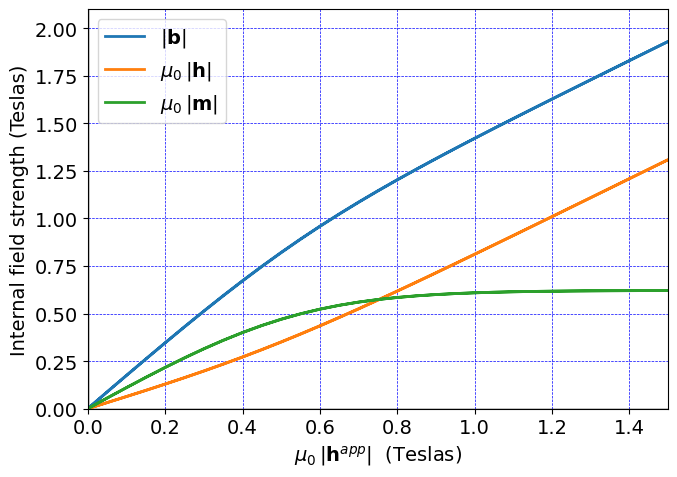

In [32]:

plt.figure()
plt.axvline(0, c='k', linewidth=1.)
plt.axhline(0, c='k', linewidth=1.)
plt.plot(float(mu0)*timeHist1[0:ind]/1e3, timeHist4[0:ind], linewidth=2.0,\
         color=colors[0], label=r'$|\mathbf{b}|$')
plt.plot(float(mu0)*timeHist1[0:ind]/1e3, timeHist3[0:ind]*float(mu0)/1e3, linewidth=2.0,\
         color=colors[1], label=r'$\mu_0\, |\mathbf{h}|$')
plt.plot(float(mu0)*timeHist1[0:ind]/1e3, timeHist5[0:ind]*float(mu0)/1e3, linewidth=2.0,\
         color=colors[2], label=r'$\mu_0\, |\mathbf{m}|$')
plt.axis('tight')
# plt.ylabel(r"$|\mathbf{b}| , \ \mu_0\,|\mathbf{h}|, \ \mu_0\,|\mathbf{m}|$, Teslas")
plt.ylabel(r"Internal field strength (Teslas)")
plt.xlabel(r"$\mu_0 \, |\mathbf{h}^{app}|$  (Teslas)")
plt.grid(linestyle="--", linewidth=0.5, color='b')
plt.ylim(0,2.1)
plt.xlim(0,1.5)
plt.legend()

fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/2D_ax_sphere_air_fields.png", dpi=600)